## basics

- references
    - https://www.youtube.com/watch?v=woXdiyezCPA
    - https://github.com/fonnesbeck/probabilistic_python

### stochastic language "primitives"

```
# distribution over value
X ~ Normal(mu, sigma)
x = X.random(n=100)  # draw 100 times

# distribution over function, 随机过程
Y ~ GaussianProcess(mean_func(x), cov_func(x))
y = Y.predict(x2)


# conditioning 
p ~ Beta(1, 1)   # random variable
z ~ Bernoulli(p) # z|p
```

$$
P(\theta | y) = \frac{P(y | \theta)P(\theta)}{P(y)}=\frac{P(y|\theta)P(\theta)}{\int_\theta P(y|\theta)P(\theta)d\theta}\\
\text{Posterior}=\frac{(\text{Likelihood of Observations})\cdot(\text{Prior Probability})}{\text{Normalizing Constant}}
$$

### pymc

In [56]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from IPython.display import Video

random_seed = 42

In [5]:
Video(url='../../imgs/nola_cb.mp4', width=400)

In [10]:
spin_rate_data = pd.read_csv('../../data/savant_data.csv', parse_dates=['game_date'])\
    .dropna(subset=['spin_rate', 'game_date'])
spin_rate_data.head()

,pitches,player_id,player_name,game_date,total_pitches,pitch_percent,ba,iso,babip,slg,...,takes,eff_min_vel,release_extension,pos3_int_start_distance,pos4_int_start_distance,pos5_int_start_distance,pos6_int_start_distance,pos7_int_start_distance,pos8_int_start_distance,pos9_int_start_distance
0,47,450203,"Morton, Charlie",2021-07-16,107,43.9,0.077,0.077,0.167,0.154,...,28,0.1,6.36,111.0,148.0,139.0,134.0,299.0,320.0,300.0
1,47,621244,"Berríos, José",2021-05-08,104,45.2,0.143,0.286,0.143,0.429,...,28,-0.2,6.31,101.0,148.0,112.0,145.0,295.0,332.0,297.0
2,46,450203,"Morton, Charlie",2021-06-17,112,41.1,0.000,0.000,0.000,0.000,...,20,-0.4,6.21,105.0,151.0,134.0,137.0,314.0,322.0,291.0
3,45,450203,"Morton, Charlie",2021-08-31,106,42.5,0.100,0.000,0.143,0.100,...,26,-0.4,6.16,114.0,153.0,139.0,143.0,296.0,317.0,298.0
4,45,450203,"Morton, Charlie",2021-06-22,107,42.1,0.000,0.000,NaN,0.000,...,27,-0.8,6.28,107.0,149.0,135.0,135.0,290.0,304.0,291.0


<Axes: xlabel='game_date', ylabel='spin_rate'>

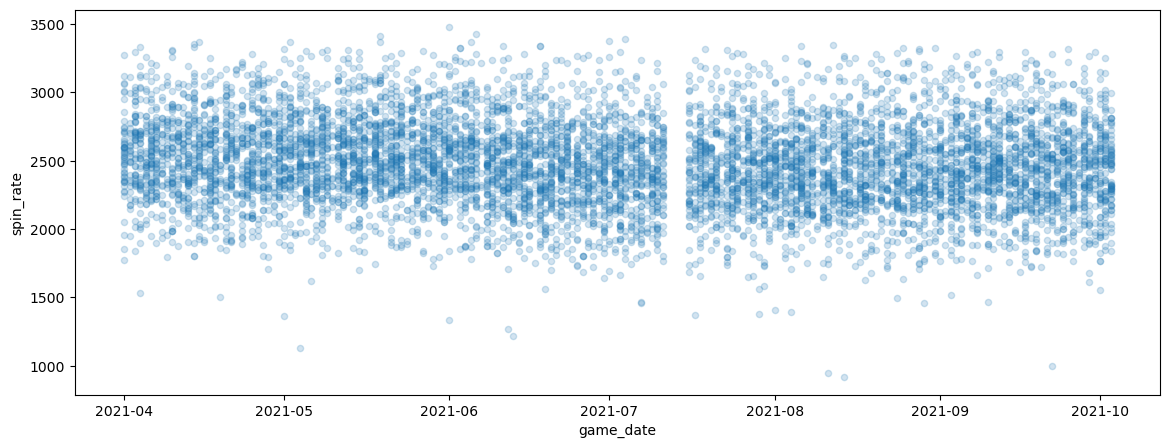

In [12]:
spin_rate_data.plot.scatter(x='game_date', y='spin_rate', figsize=(14,5), alpha=0.2)

In [22]:
# 日期按顺序编码 encode
day_ind, date = pd.factorize(spin_rate_data.game_date, sort=True)

In [49]:
spin_rate = spin_rate_data.spin_rate.values
spin_rate

array([3017., 2327., 3026., ..., 2541., 2076., 3074.])

In [33]:
print(day_ind.min(), day_ind.max())

0 181


In [34]:
np.log(1/181)

-5.198497031265825

### model

$$
r_t=\left\{
\begin{array}{lll}             
\mu_1 &\text{if}& t \lt \tau \\ 
\mu_2 &\text{if}& t \ge \tau             
\end{array}\right.\\
y_i^{(pre)} \sim \text{Normal}(\mu_1, \sigma) \\
y_i^{(post)} \sim \text{Normal}(\mu_2, \sigma)
$$


$$\mu_i \sim \text{Normal}(2500, 100)$$

$$\tau \sim \text{Uniform}(0, T)$$

$$\sigma \sim \text{HalfNormal}(100)$$

- half normal:  positive-valued;

In [54]:
with pm.Model() as spin_rate_model:
    # mu1, mu2
    mu = pm.Normal('mu', mu=2500, sigma=100, shape=2)
    tau = pm.Uniform('tau', lower=day_ind.min(), upper=day_ind.max())
    sigma = pm.HalfNormal("sigma", 100.)
    r = pm.math.switch(tau >= day_ind, mu[0], mu[1])
    spin_rate_like = pm.Normal('spin_rate_like', mu=r, sigma=sigma, observed=spin_rate) 
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, tau, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 306 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


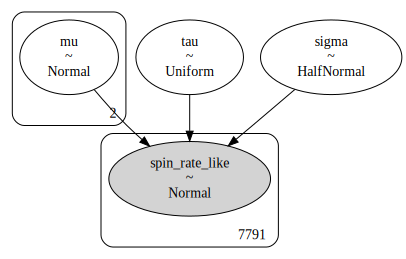

In [53]:
pm.model_to_graphviz(spin_rate_model)

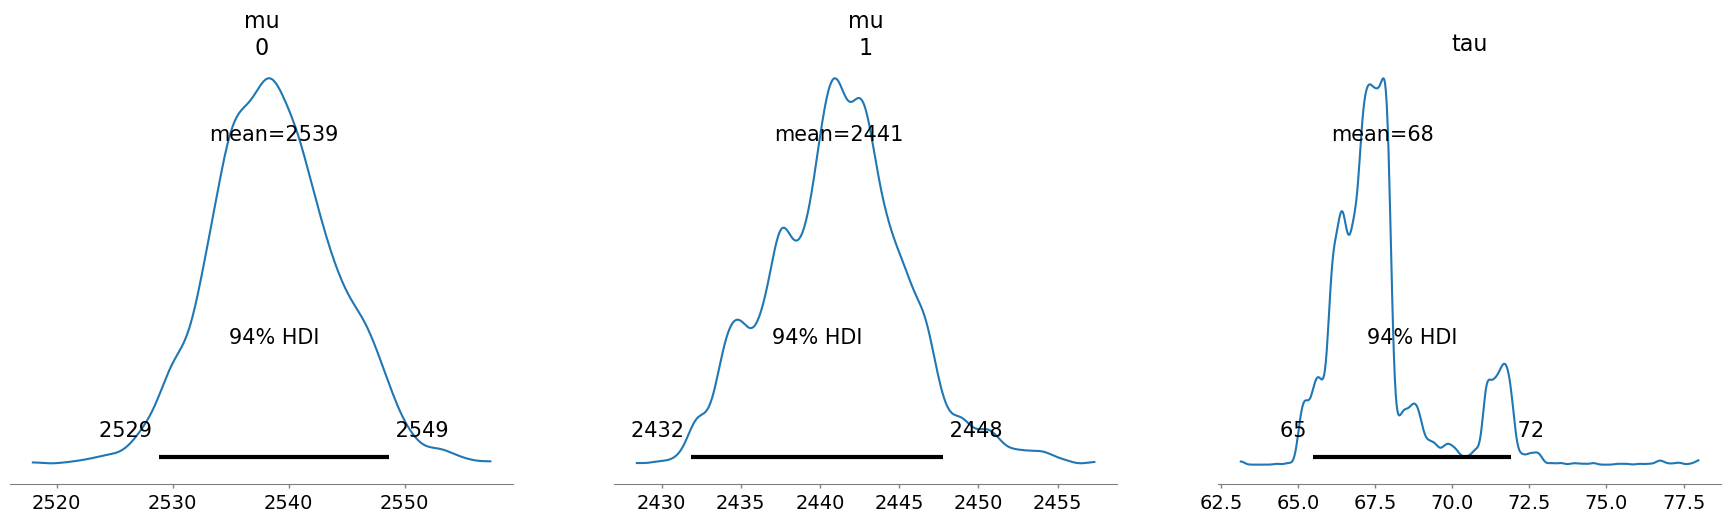

In [57]:
az.plot_posterior(trace, var_names=["mu", "tau"])

In [58]:
date[68]

Timestamp('2021-06-08 00:00:00')

### apis

In [42]:
# lpog(pdf) => log(1/181) < 0
pm.logp(tau, 5).eval()

array(-5.19849703)

In [36]:
pm.draw(mu, 5)

array([[2560.79116903, 2576.08814716],
       [2400.44293544, 2504.65800198],
       [2536.88129858, 2613.70948771],
       [2462.78162281, 2684.8025189 ],
       [2591.48143109, 2331.00562057]])

<Axes: ylabel='Count'>

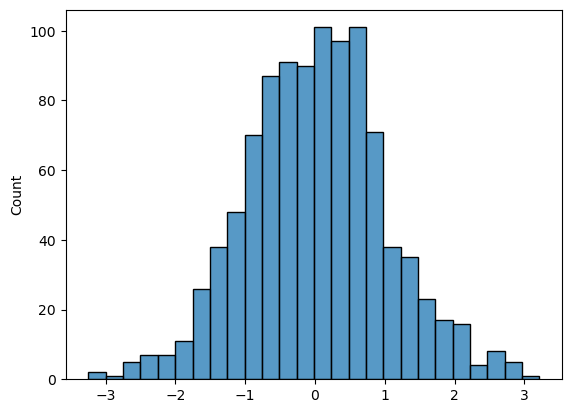

In [37]:
x = pm.Normal.dist(mu=0, sigma=1, size=1000)
sns.histplot(x.eval())

In [39]:
mu.shape.eval()

array([2])

In [51]:
print(spin_rate_model.value_vars)
print(spin_rate_model.unobserved_RVs)
print(spin_rate_model.observed_RVs)

[mu, tau_interval__, sigma_log__]
[mu, tau, sigma]
[spin_rate_like]


<Axes: ylabel='Count'>

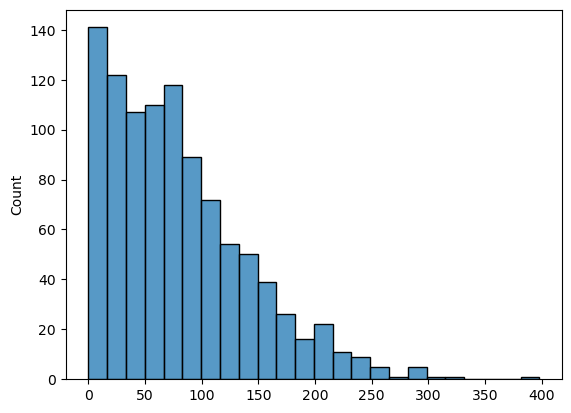

In [43]:
sns.histplot(pm.draw(sigma, 1000))

In [44]:
pm.logp(sigma, -1).eval()

array(-inf)

In [47]:
r.shape.eval()

array([7791])